In [ ]:
import torch
import json
import os
import matplotlib.pyplot as plt
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from datasets import load_dataset, concatenate_datasets
from transformers.trainer_callback import TrainerCallback
from peft import LoraConfig, get_peft_model, PeftModel
from tqdm import tqdm
import warnings

In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore")

# --- 1. Configuration (Consistent with baseline.py) ---
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
HOTPOT_DATASET_NAME = "hotpot_qa"
HOTPOT_DATASET_CONFIG = "distractor"
MATH_DATASET_NAME = "qwedsacf/competition_math"
RESULTS_DIR = "./drive/MyDrive/"

# --- Paths for this "Mixture" Experiment ---
MIXTURE_RESULTS_DIR = os.path.join(RESULTS_DIR, "mixture_experiment")
MIXTURE_ADAPTER_PATH = os.path.join(MIXTURE_RESULTS_DIR, "mixture_adapter_fp32")

# --- VRAM-Saving Config ---
MAX_SEQ_LENGTH = 2048
PER_DEVICE_BS = 32
GRAD_ACC_STEPS = 1

# --- Experiment Config ---
N_TRAIN_EXAMPLES = 4000
N_VAL_EXAMPLES = 400
JOINT_EPOCHS = 2

In [ ]:
# --- 2. Utility Functions (Data Formatting - Llama Chat Style) ---
def format_hotpot_qa(example):
    """Formats HotpotQA data into a Llama-chat-style prompt."""
    context = " ".join(["".join(s) for s in example["context"]["sentences"]])
    question = example["question"]
    answer = example["answer"]

    text = (
        f"<s>[INST] You are a helpful assistant. Use the following context to "
        f"answer the question. Context: {context}\n\nQuestion: {question} [/INST] "
        f"Answer: {answer}</s>"
    )
    return text

def format_math(example):
    """Formats MATH data into a Llama-chat-style prompt."""
    problem = example["problem"]
    solution = example["solution"]

    text = (
        f"<s>[INST] You are a math expert. Solve the following math problem. "
        f"Show your work.\nProblem: {problem} [/INST] "
        f"Solution: {solution}</s>"
    )
    return text

def filter_by_length(example, tokenizer, formatter):
    """
    Checks length only. Returns True (keep) or False (discard).
    """
    text = formatter(example)
    tokenized = tokenizer(text, max_length=MAX_SEQ_LENGTH + 1, truncation=False, padding=False)
    return len(tokenized['input_ids']) <= MAX_SEQ_LENGTH

def preprocess(example, tokenizer, formatter):
    """
    Formats text, applies loss mask, and pads to max length.
    """
    text = formatter(example)
    tokenized = tokenizer(
        text,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding="max_length", # Pad to max length
    )
    labels = tokenized["input_ids"].copy()
    inst_token_id = tokenizer.convert_tokens_to_ids("]")

    split_point = -1
    for i in range(len(tokenized["input_ids"]) - 1, -1, -1):
        if tokenized["input_ids"][i] == inst_token_id:
            split_point = i + 1
            break

    if split_point == -1:
        return {}

    for i in range(split_point):
        labels[i] = -100 # Apply loss mask

    tokenized["labels"] = labels
    return tokenized

In [ ]:
# --- 3. Model Loading (Refactored) ---

def get_model_and_tokenizer_base():
    """
    Loads the FP16 TinyLlama base model and Tokenizer.
    """
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    # Enable gradient checkpointing on the base model
    model.gradient_checkpointing_enable()

    return model, tokenizer

def get_lora_config():
    """
    Defines the LoRA configuration.
    """
    return LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=[
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
        ],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )

In [ ]:
# --- 4. Custom Callback for Joint Training ---
class JointTrainingTrackerCallback(TrainerCallback):
  """
  A callback to track performance on *both* validation sets
  during a single training run.
  """
  def __init__(self, hotpot_val, math_val, history_log, start_metrics):
      super().__init__()
      self.hotpot_eval_dataset = hotpot_val
      self.math_eval_dataset = math_val
      self.history = history_log
      self.trainer = None
      # A lock to prevent infinite evaluation loops
      self.is_evaluating = False

      # Log the initial state (Step 0)
      self.history["steps"].append(0)
      self.history["hotpot_loss"].append(start_metrics['hotpot_loss'])
      self.history["math_loss"].append(start_metrics['math_loss'])
      print("Initializing JointTrainingTrackerCallback with starting metrics.")

  def set_trainer(self, trainer):
      """Injects a reference to the trainer instance."""
      self.trainer = trainer
      print("Trainer reference set in callback.")

  def on_log(self, args, state, control, **kwargs):
      """
      Called every 'logging_steps'.
      """
      # 1. Check the lock
      if self.is_evaluating:
          return

      # 2. Acquire the lock
      self.is_evaluating = True

      if not self.trainer:
          print("WARNING: Trainer reference not set in callback, skipping eval.")
          self.is_evaluating = False # Release lock
          return

      print(f"\n--- Custom Eval at Step {state.global_step} ---")

      # Evaluate on Task B (HotpotQA)
      print("Evaluating on Task B (HotpotQA)...")
      hotpot_metrics = self.trainer.evaluate(eval_dataset=self.hotpot_eval_dataset)
      hotpot_loss = hotpot_metrics['eval_loss']
      print(f"  > Step {state.global_step} - HotpotQA Val Loss: {hotpot_loss:.4f} (LEARNING)")

      # Evaluate on Task A (MATH)
      print("Evaluating on Task A (MATH)...")
      math_metrics = self.trainer.evaluate(eval_dataset=self.math_eval_dataset)
      math_loss = math_metrics['eval_loss']
      print(f"  > Step {state.global_step} - MATH Val Loss: {math_loss:.4f} (LEARNING)")

      # Record history
      self.history["steps"].append(state.global_step)
      self.history["hotpot_loss"].append(hotpot_loss)
      self.history["math_loss"].append(math_loss)

      # 3. Release the lock
      self.is_evaluating = False

      # Ensure model is back in training mode
      self.trainer.model.train()

In [ ]:
# --- 5. Main Experiment Logic ---
def main():
    if not os.path.exists(MIXTURE_RESULTS_DIR):
        os.makedirs(MIXTURE_RESULTS_DIR)

    print(f"--- Loading Base Model & Tokenizer ---")
    base_model, tokenizer = get_model_and_tokenizer_base()

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

    # --- Load and Process Datasets ---
    print(f"\n--- Loading and Preprocessing Datasets ---")

    # Task B: HotpotQA
    raw_hotpot = load_dataset(HOTPOT_DATASET_NAME, HOTPOT_DATASET_CONFIG)
    hotpot_train = raw_hotpot["train"].shuffle(seed=42).select(range(N_TRAIN_EXAMPLES))
    hotpot_val = raw_hotpot["validation"].shuffle(seed=42).select(range(N_VAL_EXAMPLES))

    print(f"Tokenizing and filtering HotpotQA...")
    hotpot_train_tokenized = hotpot_train.filter(
        lambda x: filter_by_length(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    hotpot_val_tokenized = hotpot_val.filter(
        lambda x: filter_by_length(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_hotpot_qa),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    print(f"HotpotQA: {len(hotpot_train_tokenized)} train, {len(hotpot_val_tokenized)} val (after filtering)")

    # Task A: MATH
    raw_math = load_dataset(MATH_DATASET_NAME)
    total_math_samples_needed = N_TRAIN_EXAMPLES + N_VAL_EXAMPLES
    math_subset = raw_math["train"].shuffle(seed=42).select(range(total_math_samples_needed))
    val_size_fraction = N_VAL_EXAMPLES / total_math_samples_needed
    math_splits = math_subset.train_test_split(test_size=val_size_fraction, seed=42)
    math_train = math_splits["train"]
    math_val = math_splits["test"]

    print(f"Tokenizing and filtering MATH...")
    math_train_tokenized = math_train.filter(
        lambda x: filter_by_length(x, tokenizer, format_math),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_math),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    math_val_tokenized = math_val.filter(
        lambda x: filter_by_length(x, tokenizer, format_math),
        batched=False,
    ).map(
        lambda x: preprocess(x, tokenizer, format_math),
        batched=False,
    ).filter(lambda example: len(example) > 0)

    print(f"MATH: {len(math_train_tokenized)} train, {len(math_val_tokenized)} val (after filtering)")


    # --- Experiment: Joint Training (Mixture) ---
    print(f"\n--- Starting Experiment: Joint Training (Mixture) ---")

    # --- Prepare Model ---
    # We start with a fresh LoRA adapter on the base model
    lora_config = get_lora_config()
    mixture_model = get_peft_model(base_model, lora_config)
    mixture_model.print_trainable_parameters()

    # --- Prepare History and "Step 0" Metrics ---
    history = {"steps": [], "hotpot_loss": [], "math_loss": []}

    print("\n--- Evaluating Model at Step 0 (Before Training) ---")
    eval_args = TrainingArguments(
        output_dir=os.path.join(MIXTURE_RESULTS_DIR, "eval_temp"),
        per_device_eval_batch_size=PER_DEVICE_BS,
        report_to="none",
        gradient_checkpointing=True,
    )
    eval_trainer = Trainer(
        model=mixture_model,
        args=eval_args,
        data_collator=data_collator,
    )
    eval_hotpot_start = eval_trainer.evaluate(eval_dataset=hotpot_val_tokenized)
    eval_math_start = eval_trainer.evaluate(eval_dataset=math_val_tokenized)

    start_metrics = {
        'hotpot_loss': eval_hotpot_start['eval_loss'],
        'math_loss': eval_math_start['eval_loss'],
    }
    print(f"  > Step 0 - HotpotQA Val Loss: {start_metrics['hotpot_loss']:.4f}")
    print(f"  > Step 0 - MATH Val Loss: {start_metrics['math_loss']:.4f}")

    # Clean up the temporary eval trainer
    del eval_trainer, eval_args
    torch.cuda.empty_cache()

    # --- Prepare Joint Dataset ---
    joint_train_dataset = concatenate_datasets([hotpot_train_tokenized, math_train_tokenized]).shuffle(seed=42)

    # --- Prepare Callback ---
    tracker_callback = JointTrainingTrackerCallback(
        hotpot_val=hotpot_val_tokenized,
        math_val=math_val_tokenized,
        history_log=history,
        start_metrics=start_metrics
    )

    # --- Prepare Training Arguments ---
    joint_training_args = TrainingArguments(
        output_dir=os.path.join(MIXTURE_RESULTS_DIR, "mixture_training_temp"),
        per_device_train_batch_size=PER_DEVICE_BS,
        gradient_accumulation_steps=GRAD_ACC_STEPS,
        num_train_epochs=JOINT_EPOCHS,
        learning_rate=2e-4,
        logging_steps=30, # <-- Trigger callback every 20 steps
        save_strategy="no",
        bf16=True,
        report_to=[], # <-- Disable default reporting, use callback
        gradient_checkpointing=True,
    )

    # --- Instantiate Trainer ---
    joint_trainer = Trainer(
        model=mixture_model,
        args=joint_training_args,
        train_dataset=joint_train_dataset,
        eval_dataset=hotpot_val_tokenized, # Trainer needs a default
        data_collator=data_collator,
        callbacks=[tracker_callback] # <-- Pass the custom callback
    )

    # Link trainer instance back to callback
    tracker_callback.set_trainer(joint_trainer)

    # --- Run Training ---
    print(f"--- Starting Joint Training ---")
    joint_trainer.train()

    print(f"--- Joint training complete. Saving adapter to {MIXTURE_ADAPTER_PATH} ---")
    mixture_model.save_pretrained(MIXTURE_ADAPTER_PATH)
    print("Adapter saved.")

    # --- 6. Plot Results ---
    print("\n--- Saving History Data and Generating Plot ---")

    # --- Save history data to JSON ---
    history_filename = os.path.join(MIXTURE_RESULTS_DIR, "joint_training_history_fp32.json")
    try:
        with open(history_filename, 'w') as f:
            json.dump(history, f, indent=4)
        print(f"History data saved to {history_filename}")
    except Exception as e:
        print(f"Error saving history to JSON: {e}")
    # --- [END] ---

    plt.figure(figsize=(12, 6))
    plt.plot(history["steps"], history["hotpot_loss"], 'o-', label="Task B (HotpotQA) Loss", color="blue")
    plt.plot(history["steps"], history["math_loss"], 'o-', label="Task A (MATH) Loss", color="red")

    plt.title(f"Joint Training (Mixture): MATH + HotpotQA (Model: {MODEL_NAME} FP32 LoRA)")
    plt.xlabel(f"Training Steps on Mixed Dataset (Total Epochs: {JOINT_EPOCHS})")
    plt.ylabel("Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()

    plot_filename = os.path.join(MIXTURE_RESULTS_DIR, "joint_training_curve_fp32.png")
    plt.savefig(plot_filename)
    print(f"Plot saved to {plot_filename}")

    try:
        from google.colab import files
        plt.show()
    except ImportError:
        print("Not in Colab, plot saved to file.")

INFO: Running on GPU. VRAM: 42.47 GB
--- Loading Base Model & Tokenizer ---


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]


--- Loading and Preprocessing Datasets ---


README.md: 0.00B [00:00, ?B/s]

distractor/train-00000-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/train-00001-of-00002.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

distractor/validation-00000-of-00001.par(…):   0%|          | 0.00/27.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Tokenizing and filtering HotpotQA...


Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3686 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3686 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/367 [00:00<?, ? examples/s]

Filter:   0%|          | 0/367 [00:00<?, ? examples/s]

HotpotQA: 3686 train, 367 val (after filtering)


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-7320a6f3aba8eb(…):   0%|          | 0.00/4.85M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12500 [00:00<?, ? examples/s]

Tokenizing and filtering MATH...


Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3994 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3994 [00:00<?, ? examples/s]

Filter:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Filter:   0%|          | 0/399 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


MATH: 3994 train, 399 val (after filtering)

--- Starting Experiment: Joint Training (Mixture) ---
trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044

--- Evaluating Model at Step 0 (Before Training) ---


The model is already on multiple devices. Skipping the move to device specified in `args`.


  > Step 0 - HotpotQA Val Loss: 1.8861
  > Step 0 - MATH Val Loss: 1.5623
Initializing JointTrainingTrackerCallback with starting metrics.
Trainer reference set in callback.
--- Starting Joint Training ---


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
30,1.697900,1.129461
60,1.594600,1.075173
90,1.588400,1.051868
120,1.570900,1.033528
150,1.573900,1.023659
180,1.561500,1.016921
210,1.571900,1.011289
240,1.571100,1.007246
270,1.551300,1.003595
300,1.558200,1.000427



--- Custom Eval at Step 30 ---
Evaluating on Task B (HotpotQA)...
  > Step 30 - HotpotQA Val Loss: 1.7643 (LEARNING)
Evaluating on Task A (MATH)...
  > Step 30 - MATH Val Loss: 1.1295 (LEARNING)

--- Custom Eval at Step 60 ---
Evaluating on Task B (HotpotQA)...
  > Step 60 - HotpotQA Val Loss: 1.7490 (LEARNING)
Evaluating on Task A (MATH)...
  > Step 60 - MATH Val Loss: 1.0752 (LEARNING)

--- Custom Eval at Step 90 ---
Evaluating on Task B (HotpotQA)...
  > Step 90 - HotpotQA Val Loss: 1.7422 (LEARNING)
Evaluating on Task A (MATH)...
  > Step 90 - MATH Val Loss: 1.0519 (LEARNING)

--- Custom Eval at Step 120 ---
Evaluating on Task B (HotpotQA)...
  > Step 120 - HotpotQA Val Loss: 1.7387 (LEARNING)
Evaluating on Task A (MATH)...
  > Step 120 - MATH Val Loss: 1.0335 (LEARNING)

--- Custom Eval at Step 150 ---
Evaluating on Task B (HotpotQA)...
  > Step 150 - HotpotQA Val Loss: 1.7352 (LEARNING)
Evaluating on Task A (MATH)...
  > Step 150 - MATH Val Loss: 1.0237 (LEARNING)

--- Custom Ev

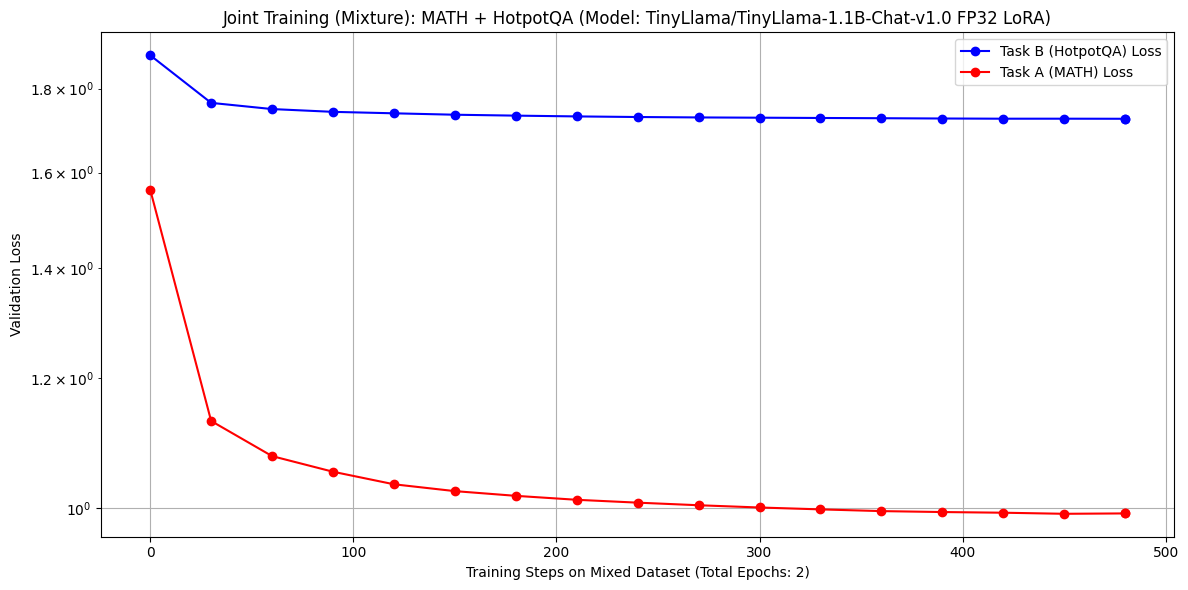

In [ ]:
if __name__ == "__main__":
    if not torch.cuda.is_available():
        print("ERROR: This experiment requires a GPU. Check Colab runtime type.")
    else:
        print(f"INFO: Running on GPU. VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
